In [1]:
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from _csv import writer
from scipy.special import softmax
import torch
import pandas as pd
import html
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [2]:
# Load the data in a dataframe
pd.set_option('max_colwidth', None)
pd.set_option('display.width', 3000)
df =pd.read_csv("new_sample_sort.csv",usecols=["tweet","sentiment"])

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(df.tweet)

CountVectorizer()

In [4]:
len(cvec.get_feature_names_out())

18327

In [5]:
df.tail()

,tweet,sentiment
7263,looking forward speaking 3dao web3 unconference november alongside fantastic global educators ill running learning lab session incorporating microcredentials junior science come join us web3 education metaverse,positive
7264,getting real cant wait see ya cnftproject cnft cnftcommunity nft metaverse,positive
7265,11 shine giant 64 ft xr screen light amazing work whos creating incredible 3d animation cryptoart web3 metaverse long time,positive
7266,14 excited announce partnership collective sol ogs elevating indie artists within ecosystem whats partnership well well hosting skullana fest metaverse keep reading,positive
7267,tweet,sentiment


In [6]:
import numpy as np

In [7]:
neg_doc_matrix = cvec.transform(df[df.sentiment == "negative"].tweet)
pos_doc_matrix = cvec.transform(df[df.sentiment == "positive"].tweet)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(df.tweet)

CountVectorizer(max_features=10000, stop_words='english')

In [9]:
document_matrix = cvec.transform(df.tweet)

In [10]:
%%time
pos_batches = np.linspace(4582,7266,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print(pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

4880 entries' term freuquency calculated
5178 entries' term freuquency calculated
5476 entries' term freuquency calculated
5774 entries' term freuquency calculated
6073 entries' term freuquency calculated
6371 entries' term freuquency calculated
6669 entries' term freuquency calculated
6967 entries' term freuquency calculated
7266 entries' term freuquency calculated
CPU times: user 50.6 ms, sys: 33.6 ms, total: 84.2 ms
Wall time: 90.1 ms


In [11]:
%%time
neg_batches = np.linspace(0,123,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1


13 entries' term freuquency calculated
27 entries' term freuquency calculated
41 entries' term freuquency calculated
54 entries' term freuquency calculated
68 entries' term freuquency calculated
82 entries' term freuquency calculated
95 entries' term freuquency calculated
109 entries' term freuquency calculated
123 entries' term freuquency calculated
CPU times: user 4.49 ms, sys: 1.99 ms, total: 6.48 ms
Wall time: 5.07 ms


In [12]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
metaverse,132,3013,3145
nft,27,865,892
web3,21,728,749
nfts,20,581,601
crypto,12,355,367
nftcommunity,12,339,351
new,4,279,283
blockchain,1,222,223
join,2,215,217
great,3,207,210


Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

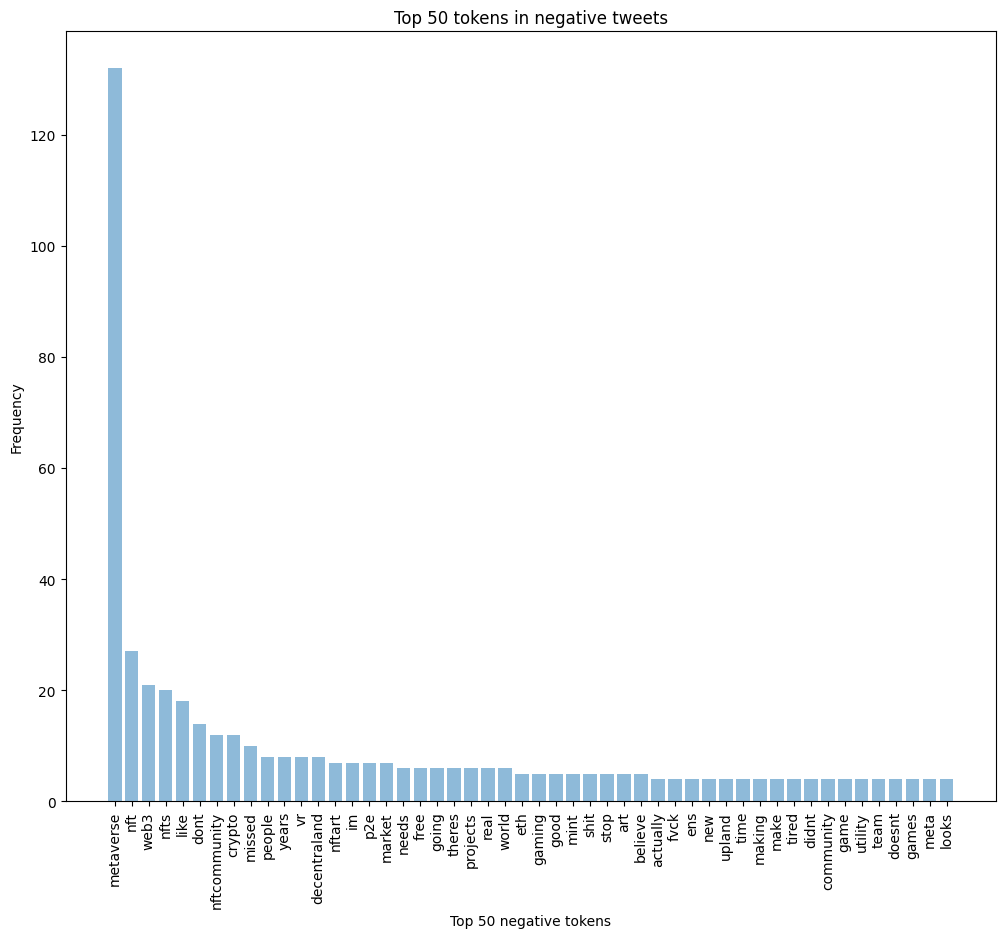

In [13]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

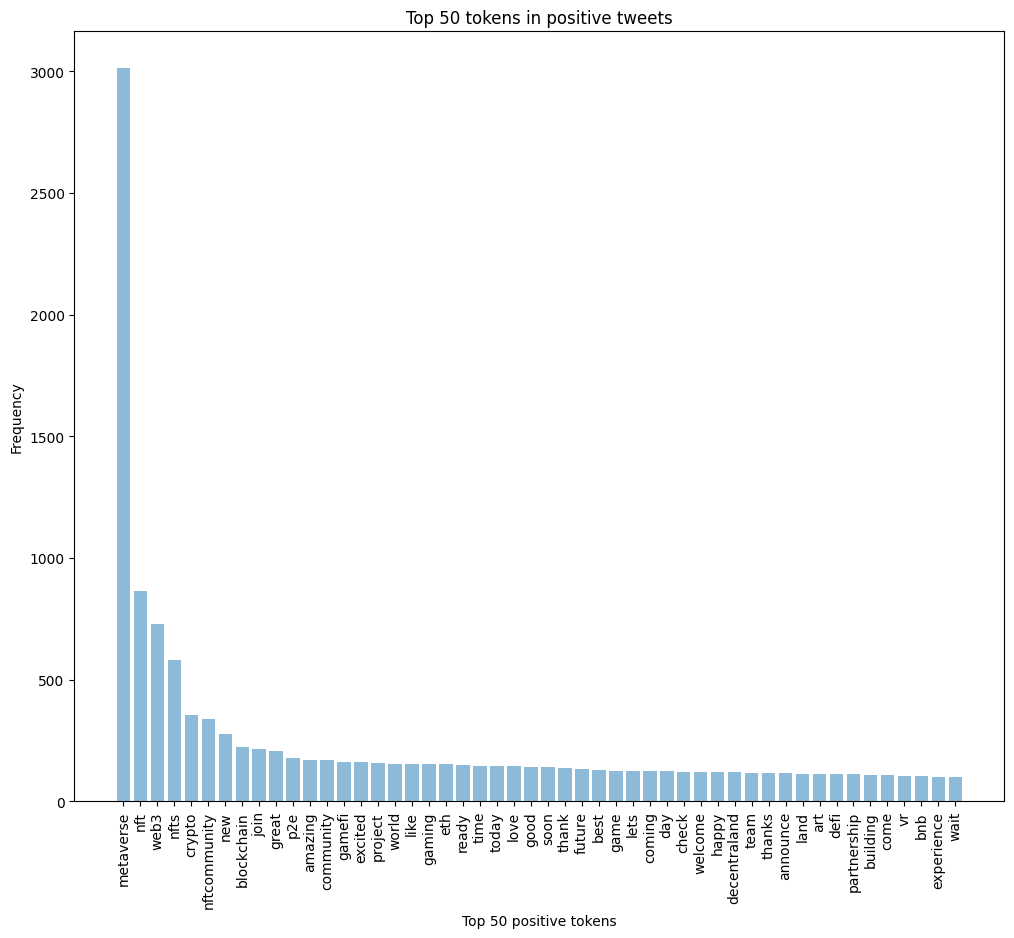

In [14]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

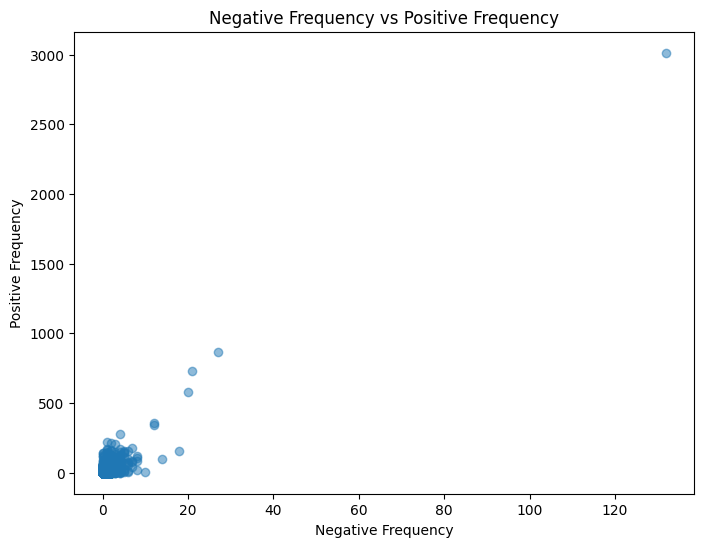

In [15]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [16]:

term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
00000008,0,1,1,1.0
pikchu,0,1,1,1.0
pins,0,1,1,1.0
pinned,0,3,3,1.0
pinnacle,0,1,1,1.0
pinksale,0,3,3,1.0
pink,0,1,1,1.0
pingcap,0,2,2,1.0
pinetwork,0,2,2,1.0
pinball,0,1,1,1.0


In [17]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
metaverse,132,3013,3145,0.958029,0.066547
nft,27,865,892,0.969731,0.019105
web3,21,728,749,0.971963,0.016079
nfts,20,581,601,0.966722,0.012832
crypto,12,355,367,0.967302,0.007841
nftcommunity,12,339,351,0.965812,0.007487
new,4,279,283,0.985866,0.006162
blockchain,1,222,223,0.995516,0.004903
join,2,215,217,0.990783,0.004749
great,3,207,210,0.985714,0.004572


In [18]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
metaverse,132,3013,3145,0.958029,0.066547,0.124450
nft,27,865,892,0.969731,0.019105,0.037472
web3,21,728,749,0.971963,0.016079,0.031635
nfts,20,581,601,0.966722,0.012832,0.025329
crypto,12,355,367,0.967302,0.007841,0.015556
nftcommunity,12,339,351,0.965812,0.007487,0.014860
new,4,279,283,0.985866,0.006162,0.012248
blockchain,1,222,223,0.995516,0.004903,0.009758
join,2,215,217,0.990783,0.004749,0.009452
great,3,207,210,0.985714,0.004572,0.009102


In [28]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:50]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
love,0,145,145,1.000000,0.003203,0.006385,0.610678,0.999967,0.758277,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
thank,0,138,138,1.000000,0.003048,0.006077,0.610678,0.999925,0.758265,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
best,0,130,130,1.000000,0.002871,0.005726,0.610678,0.999816,0.758234,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
thanks,0,118,118,1.000000,0.002606,0.005199,0.610678,0.999363,0.758103,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
partnership,0,111,111,1.000000,0.002452,0.004891,0.610678,0.998749,0.757927,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
giveaway,0,88,88,1.000000,0.001944,0.003880,0.610678,0.991107,0.755716,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
fun,0,85,85,1.000000,0.001877,0.003748,0.610678,0.988839,0.755055,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
forward,0,80,80,1.000000,0.001767,0.003528,0.610678,0.983939,0.753622,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217
blockchain,1,222,223,0.995516,0.004903,0.009758,0.601355,1.000000,0.751057,0.004484,0.000573,0.001016,0.398645,0.707359,0.509917
ethereum,0,70,70,1.000000,0.001546,0.003087,0.610678,0.968483,0.749045,0.000000,0.000000,0.000000,0.389322,0.454083,0.419217


In [20]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
missed,10,6,16,0.375000,0.000133,0.000265,9.805345e-04,0.516673,1.957354e-03,0.625000,0.005731,0.011357,0.999019,1.000000,0.999509
shit,5,3,8,0.375000,0.000066,0.000132,9.805345e-04,0.482702,1.957094e-03,0.625000,0.002865,0.005705,0.999019,0.999288,0.999154
needs,6,5,11,0.454545,0.000110,0.000221,3.835172e-03,0.505351,7.612571e-03,0.545455,0.003438,0.006834,0.996165,0.999941,0.998049
tired,4,0,4,0.000000,0.000000,0.000000,1.508704e-07,0.448856,3.017407e-07,1.000000,0.002292,0.004574,1.000000,0.994277,0.997130
fvck,4,0,4,0.000000,0.000000,0.000000,1.508704e-07,0.448856,3.017407e-07,1.000000,0.002292,0.004574,1.000000,0.994277,0.997130
doesnt,4,4,8,0.500000,0.000088,0.000177,7.746703e-03,0.494024,1.525421e-02,0.500000,0.002292,0.004564,0.992253,0.994277,0.993264
trying,4,4,8,0.500000,0.000088,0.000177,7.746703e-03,0.494024,1.525421e-02,0.500000,0.002292,0.004564,0.992253,0.994277,0.993264
didnt,4,5,9,0.555556,0.000110,0.000221,1.698430e-02,0.505351,3.286407e-02,0.444444,0.002292,0.004561,0.983016,0.994277,0.988614
fuck,3,0,3,0.000000,0.000000,0.000000,1.508704e-07,0.448856,3.017407e-07,1.000000,0.001719,0.003432,1.000000,0.969102,0.984309
lost,3,1,4,0.250000,0.000022,0.000044,8.113590e-05,0.460109,1.622432e-04,0.750000,0.001719,0.003431,0.999919,0.969102,0.984270


Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

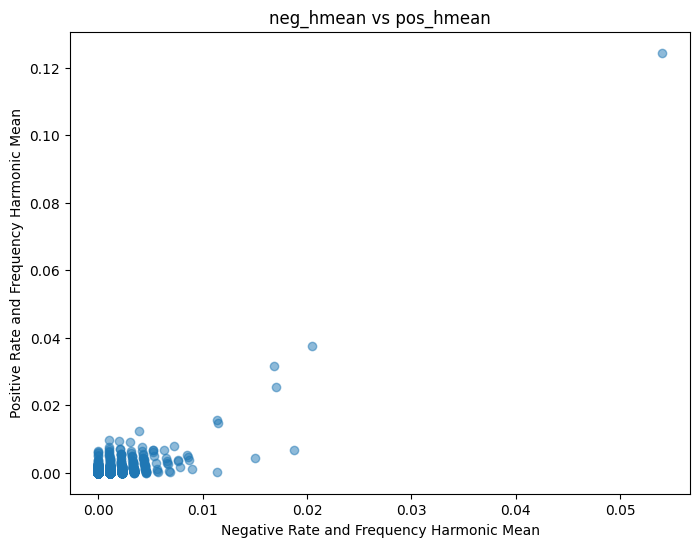

In [21]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

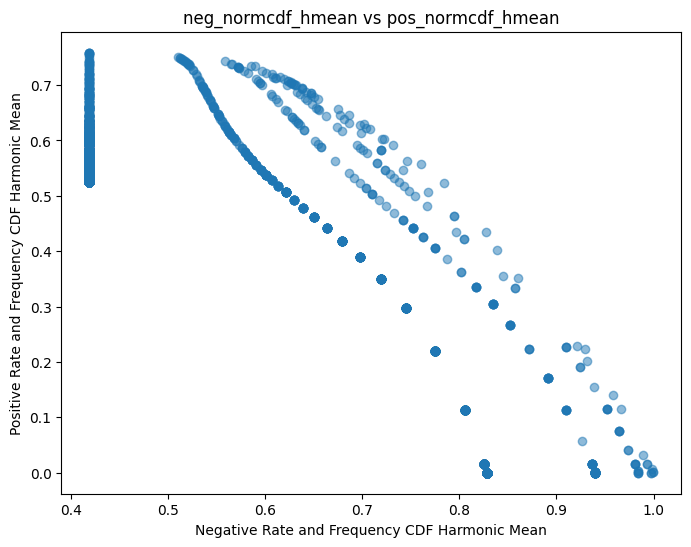

In [22]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [25]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...